# Readme
This notebook is used to prepare the data from which all the results are then computed. The main reason is that the original data file is too large to be shared, and also the computation of the performance curves is a bit time consuming.

In [20]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import ast
import json
import pickle

import matplotlib.pyplot as plt


compute_metrics_of_datasets = False
OPTIMIZERS = ["auto-sklearn", "gama", "naive-python", "seminaive-python"]
OPTIMIZER_COLORS = {"auto-sklearn": "C0", "gama": "C1", "naive-python": "C2", "seminaive-python": "C3"}
OPTIMIZER_NAMES = {"auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive-python": "naive", "seminaive-python": "quasi-naive"}

In [2]:
dfResults = pd.read_csv("results.csv", delimiter=";")

In [3]:
dfResults = dfResults[(dfResults["exception"].isna()) & (dfResults["metric"].notna())]
dfResults = dfResults[(dfResults["algorithm"].isin(OPTIMIZERS))]
dfResults

,experiment_id,openmlid,seed,algorithm,timeout,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,metric,onlinedata,exception,time_end
0,1,1485,0,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node03-021,oculus-8071927-100,2021-07-11 03:16:05,"[(1.000000, SimpleClassificationPipeline({'bal...",0.123077,0.951657,"{""mean_test_score"":[""0.7974705968295712"",""0.0""...",NaN,2021-07-11 04:16:23
1,2,1485,1,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-033,oculus-8071927-8,2021-07-11 02:47:25,"[(1.000000, SimpleClassificationPipeline({'bal...",0.161538,0.925444,"{""mean_test_score"":[""0.8008510482869458"",""0.0""...",NaN,2021-07-11 03:47:33
2,3,1590,0,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node09-010,oculus-8071927-20,2021-07-11 02:47:25,"[(1.000000, SimpleClassificationPipeline({'bal...",0.159910,0.892736,"{""mean_test_score"":[""0.0"",""0.8793787893583406""...",NaN,2021-07-11 03:47:45
3,4,1590,1,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-018,oculus-8071927-164,2021-07-11 03:00:29,"[(1.000000, SimpleClassificationPipeline({'bal...",0.223587,0.887001,"{""mean_test_score"":[""0.0"",""0.8793718597299466""...",NaN,2021-07-11 04:00:51
4,5,1485,2,auto-sklearn,3600,8,24000,2021-07-06 20:49:27,node04-016,oculus-8071927-6,2021-07-11 02:47:27,"[(1.000000, SimpleClassificationPipeline({'bal...",0.111538,0.946391,"{""mean_test_score"":[""0.7950635546789393"",""0.0""...",NaN,2021-07-11 03:47:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6432,7366,31,7,gama,86400,8,24000,2021-07-22 15:01:30,node11-047,oculus-8411525-197,2021-07-29 08:26:52,"Pipeline(steps=[('1',\n RBFSam...",0.240000,0.784286,"[[6.1085309982299805,""ExtraTreesClassifier(dat...",NaN,2021-07-30 06:03:40
6433,7367,40975,8,gama,86400,8,24000,2021-07-22 15:01:30,node07-032,oculus-8411525-484,2021-07-29 10:30:28,"Pipeline(steps=[('0',\n HistGr...",0.000000,0.000562,"[[0.12378478050231934,""KNeighborsClassifier(da...",NaN,2021-07-30 08:06:50
6434,7368,31,8,gama,86400,8,24000,2021-07-22 15:01:30,node09-041,oculus-8411525-498,2021-07-29 07:52:12,"Pipeline(steps=[('0',\n Random...",0.300000,0.828095,"[[0.029227018356323242,""GradientBoostingClassi...",NaN,2021-07-30 05:28:38
6435,7369,40975,9,gama,86400,8,24000,2021-07-22 15:01:30,node02-028,oculus-8411525-217,2021-07-29 07:36:09,"Pipeline(steps=[('0',\n HistGr...",0.000000,0.000174,"[[4.302340984344482,""RandomForestClassifier(da...",NaN,2021-07-30 05:12:31


In [14]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
if compute_metrics_of_datasets:
    rows = []
    metrics = {}
    for openmlid in datasets:
        dataset = openml.datasets.get_dataset(openmlid)
        num_classes = int(dataset.qualities["NumberOfClasses"])
        metrics[openmlid] = "auc" if num_classes == 2 else "log_loss"
    datasetnames = {openmlid: openml.datasets.get_dataset(openmlid).name for openmlid in datasets}
else: # re-use previously computed metrics
    metrics = {1485: 'auc', 1590: 'auc', 1515: 'log_loss', 1457: 'log_loss', 1475: 'log_loss', 1468: 'log_loss', 1486: 'auc', 1489: 'auc', 23512: 'auc', 23517: 'auc', 4541: 'log_loss', 4534: 'auc', 4538: 'log_loss', 4134: 'auc', 4135: 'auc', 40978: 'auc', 40996: 'log_loss', 41027: 'log_loss', 40981: 'auc', 40982: 'log_loss', 40983: 'auc', 40984: 'log_loss', 40701: 'auc', 40670: 'log_loss', 40685: 'log_loss', 40900: 'auc', 1111: 'auc', 42732: 'auc', 42733: 'auc', 42734: 'log_loss', 40498: 'log_loss', 41161: 'auc', 41162: 'auc', 41163: 'log_loss', 41164: 'log_loss', 41165: 'log_loss', 41166: 'log_loss', 41167: 'log_loss', 41168: 'log_loss', 41169: 'log_loss', 41142: 'auc', 41143: 'auc', 41144: 'auc', 41145: 'auc', 41146: 'auc', 41147: 'auc', 41150: 'auc', 41156: 'auc', 41157: 'auc', 41158: 'auc', 41159: 'auc', 41138: 'auc', 54: 'log_loss', 181: 'log_loss', 188: 'log_loss', 1461: 'auc', 1494: 'auc', 1464: 'auc', 12: 'log_loss', 23: 'log_loss', 3: 'auc', 1487: 'auc', 40668: 'log_loss', 1067: 'auc', 1049: 'auc', 40975: 'log_loss', 31: 'auc'}
    datasetnames = {1485: 'madelon', 1590: 'adult', 1515: 'micro-mass', 1457: 'amazon-commerce-reviews', 1475: 'first-order-theorem-proving', 1468: 'cnae-9', 1486: 'nomao', 1489: 'phoneme', 23512: 'higgs', 23517: 'numerai28.6', 4541: 'Diabetes130US', 4534: 'PhishingWebsites', 4538: 'GesturePhaseSegmentationProcessed', 4134: 'Bioresponse', 4135: 'Amazon_employee_access', 40978: 'Internet-Advertisements', 40996: 'Fashion-MNIST', 41027: 'jungle_chess_2pcs_raw_endgame_complete', 40981: 'Australian', 40982: 'steel-plates-fault', 40983: 'wilt', 40984: 'segment', 40701: 'churn', 40670: 'dna', 40685: 'shuttle', 40900: 'Satellite', 1111: 'KDDCup09_appetency', 42732: 'sf-police-incidents', 42733: 'Click_prediction_small', 42734: 'okcupid-stem', 40498: 'wine-quality-white', 41161: 'riccardo', 41162: 'kick', 41163: 'dilbert', 41164: 'fabert', 41165: 'robert', 41166: 'volkert', 41167: 'dionis', 41168: 'jannis', 41169: 'helena', 41142: 'christine', 41143: 'jasmine', 41144: 'madeline', 41145: 'philippine', 41146: 'sylvine', 41147: 'albert', 41150: 'MiniBooNE', 41156: 'ada', 41157: 'arcene', 41158: 'gina', 41159: 'guillermo', 41138: 'APSFailure', 54: 'vehicle', 181: 'yeast', 188: 'eucalyptus', 1461: 'bank-marketing', 1494: 'qsar-biodeg', 1464: 'blood-transfusion-service-center', 12: 'mfeat-factors', 23: 'cmc', 3: 'kr-vs-kp', 1487: 'ozone-level-8hr', 40668: 'connect-4', 1067: 'kc1', 1049: 'pc4', 40975: 'car', 31: 'credit-g'}

datasets_auc = [i for i, metric in metrics.items() if metric == "auc"]
datasets_logloss = [i for i, metric in metrics.items() if metric == "log_loss"]

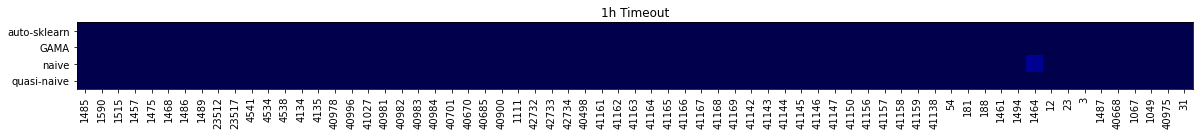

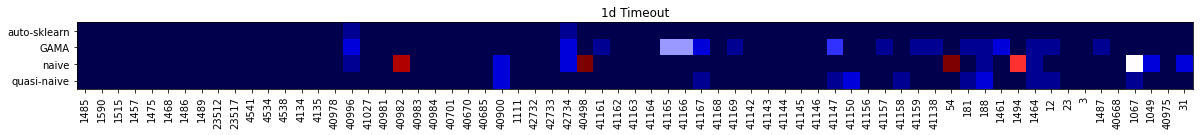

In [5]:
def plotAvailability(df):
    Z = np.zeros((len(datasets), len(OPTIMIZERS)))
    for i, openmlid in enumerate(datasets):
        for j, algo in enumerate(OPTIMIZERS):
            Z[i,j] = np.count_nonzero((df["algorithm"] == algo) & (df["openmlid"] == openmlid))
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.imshow(-Z.T, cmap="seismic", vmin = -10, vmax=0)
    ax.set_yticks(range(len(OPTIMIZERS)))
    ax.set_yticklabels([OPTIMIZER_NAMES[o] for o in OPTIMIZERS])
    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets, rotation=90)
    return ax

ax = plotAvailability(dfResults[dfResults["timeout"] == 3600])
ax.set_title("1h Timeout")
plt.show()
ax = plotAvailability(dfResults[dfResults["timeout"] == 86400])
ax.set_title("1d Timeout")
plt.show()

In [6]:
def get_runtime(time_start, time_end):
    timestamp_start = datetime.datetime.timestamp(datetime.datetime.strptime(time_start, "%Y-%m-%d %H:%M:%S"))
    timestamp_end = datetime.datetime.timestamp(datetime.datetime.strptime(time_end, "%Y-%m-%d %H:%M:%S"))
    return timestamp_end - timestamp_start

def get_curve_for_autosklearn(dataframe, metric, T = None):
    cases = []
    for i, case in enumerate(dataframe["onlinedata"].values):
        try:
            case_parsed = ast.literal_eval(case)
            timestamps = [int(t) for t in case_parsed["timestamps"]]
            scores = np.array(case_parsed["mean_test_score"]).astype(float)
            if metric != "auc":
                scores *= -1
            if len(timestamps) != len(scores):
                del timestamps[-1]
            exp_timestamps = dataframe[["timeout", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            cases.append((timestamps, scores, runtime))
        except ValueError:
            print("Ignoring case with error")
    return get_curve_for_cases(cases, T)

def get_curve_for_naive(dataframe, T = None):
    cases = []
    for i, case in enumerate(dataframe["onlinedata"].values):
        try:
            case_parsed = ast.literal_eval(case)
            timestamps = [e[0] for e in case_parsed]
            scores = [e[2] for e in case_parsed]
            exp_timestamps = dataframe[["timeout", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            cases.append((timestamps, scores, runtime))
        except ValueError:
            print("Ignoring case with error")
            print("\t", case)
    return get_curve_for_cases(cases, T)
    
def get_curve_for_cases(cases, T = None):
    
    if not cases:
        return {
            "times": np.array([]),
            "mean": np.array([]),
            "median": np.array([]),
            "q1": np.array([]),
            "q3": np.array([])
        }
    
    # clean cases by removing non-monotone observations
    cleaned_cases = []
    for timestamps, scores, termination in cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        scores_n = []
        timestamps_n = []
        for i, t in enumerate(timestamps):
            score = scores[i]
            if not scores_n or score > scores_n[-1]:
                timestamps_n.append(t)
                scores_n.append(score)
        cleaned_cases.append((timestamps_n, scores_n, termination))
            
    
    # get anchors for which we need to provide curve information
    anchors = set([])
    max_runtime = 0
    for timestamps, scores, termination in cleaned_cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        for i, t in enumerate(timestamps):
            anchors.add(t)
        
        max_runtime = max(max_runtime, termination)
    
    # now compute all relevant metrics for each point
    times = sorted(anchors)
    if T is not None:
        times = [t for t in times if t < T] + [min(T, max_runtime)]
        
    curve = []
    for t in times:
        
        # get latest valid score of each case at this point
        vals = []
        for ts, scores, termination in cleaned_cases:
            mask = [v <= t for v in ts]
            if not True in mask:
                val = -np.inf
            elif not False in mask:
                val = scores[-1]
            else:
                index = mask.index(False) - 1
                val = scores[index]
            vals.append(val if val > -10**4 else -np.inf)
        curve.append(vals)
    curve = np.array(curve).T
    return {
        "times": np.array(times),
        "mean": np.mean(curve, axis=0),
        "median": np.median(curve, axis=0),
        "q1": np.percentile(curve, 25, axis=0),
        "q3": np.percentile(curve, 75, axis=0)
    }

def get_performance_curves(df, timeout):
    performance_curves = {}
    for openmlid, dfDataset in tqdm(df[df["timeout"] == timeout].groupby("openmlid")):
        metric = metrics[openmlid]
        curves = {}
        curves["auto-sklearn"] = get_curve_for_autosklearn(dfDataset[(dfDataset["algorithm"] == "auto-sklearn")], metric, T=timeout)
        curves["seminaive-python"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'seminaive-python')], T=timeout)
        curves["naive-python"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'naive-python')], T=timeout)
        curves["gama"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'gama')], T=timeout)
        performance_curves[openmlid] = curves
    return performance_curves

## Compute and Serialize Performance Curves

In [15]:
performance_curves_1h = get_performance_curves(dfResults, 3600)

In [16]:
performance_curves_1d = get_performance_curves(dfResults, 86400)

In [18]:
with open('performancecurves.pickle', 'wb') as f:
    pickle.dump({"1h": performance_curves_1h, "1d": performance_curves_1d}, f, protocol=0)

In [19]:
dfResults[["timeout", "openmlid", "seed", "algorithm", "metric"]].to_csv("results_final.csv", index=False)